# AlongTrack Data

In [1]:
import autoroot
from pathlib import Path
from tqdm.auto import tqdm
from geo_toolz._src.data.ocean.ssh.alongtrack import download_alongtrack_data_new, ALONGTRACK_NAMES_NEW
from geo_toolz._src.validation.coords import validate_latitude, validate_longitude
from geo_toolz._src.subset.where import where_slice_bbox
from geo_toolz._src.validation.ssh import validate_ssh
from geo_toolz._src.kinematics.ssh import calculate_ssh_alongtrack
from geo_toolz._src.utils.io import get_list_filenames
import matplotlib.pyplot as plt
import numpy as np
import pyinterp
from geo_toolz._src.discretize.grid import RegularLonLat, RegularLonLatTime
from geo_toolz._src.discretize.period import Period
from geo_toolz._src.discretize.binning import da_binning_2D, da_binning_2D_Time, ds_binning_2D_Time

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Target

In [2]:
lon_bnds = [-66, -54]
lat_bnds = [32, 44]
resolution = 1/5
target_grid = RegularLonLat.init_from_bounds(lon_bnds, lat_bnds, resolution)
target_grid

RegularLonLat(bbox=BoundingBox(left=-66, bottom=32, right=-54, top=44, crs=CRS('EPSG:4326')), resolution=0.2, gbox=GeoBox((60, 60), Affine(0.2, 0.0, -66.0,
       0.0, -0.2, 44.0), CRS('EPSG:4326')), coordinates=<xarray.Dataset>
Dimensions:      (lat: 60, lon: 60)
Coordinates:
  * lat          (lat) float64 43.9 43.7 43.5 43.3 43.1 ... 32.7 32.5 32.3 32.1
  * lon          (lon) float64 -65.9 -65.7 -65.5 -65.3 ... -54.5 -54.3 -54.1
Data variables:
    spatial_ref  int32 4326)

In [3]:
time_min = "2024-01-01"
time_max = "2024-02-01"
step = 5
unit = "D"
target_grid = RegularLonLatTime.init_from_bounds(lon_bnds, lat_bnds, resolution, time_min, time_max, time_step=step, time_unit=unit)

## Data

In [4]:
ALONGTRACK_NAMES_NEW

['al', 'c2n', 'h2b', 'al', 'j3n', 's3a', 's3b', 's6a', 'swon']

In [5]:
time_min = "2024-01-01"
time_max = "2024-02-01"
satellite = "s3a"

download_dir = Path("/pool/usuarios/juanjohn/data/ocean/obs/alongtrack/nadir")
output_directory = download_dir.joinpath(satellite)
output_directory.mkdir(exist_ok=True, parents=True)


In [6]:
# download_alongtrack_data_new(satellite=satellite, time_min=time_min, time_max=time_max, output_directory=output_directory) 

In [7]:
!ls /pool/usuarios/juanjohn/data/ocean/obs/alongtrack/nadir/c2/

SEALEVEL_GLO_PHY_L3_MY_008_062


In [8]:
import xarray as xr

download_dir = Path(f"/pool/usuarios/juanjohn/data/ocean/obs/alongtrack/nadir/{satellite}")
list_of_files = get_list_filenames(download_dir, ext="*.nc")
len(list_of_files)

246

In [9]:
# list_of_files

## Preprocessing

In [10]:
def pipe(ds):
    ds = validate_longitude(ds)
    ds = validate_latitude(ds)
    # subset data
    ds = where_slice_bbox(ds, bbox=target_grid.bbox)
    # calculate variables
    ds = calculate_ssh_alongtrack(ds)
    ds = validate_ssh(ds)
    ds = ds.sortby("time")
    # subset variables
    ds = ds[["ssh", "sla_unfiltered"]]
    return ds

In [11]:
ds = xr.open_mfdataset(
    list_of_files, 
    preprocess=pipe,
    combine="nested",
    engine="netcdf4")

In [12]:
ds

<xarray.Dataset>
Dimensions:         (time: 46150)
Coordinates:
  * time            (time) datetime64[ns] 2022-09-10T01:32:30.303757312 ... 2...
    lon             (time) float64 -58.48 -58.5 -58.52 ... -56.63 -56.65 -56.67
    lat             (time) float64 32.03 32.09 32.15 32.21 ... 43.84 43.9 43.96
Data variables:
    ssh             (time) float32 dask.array<chunksize=(46150,), meta=np.ndarray>
    sla_unfiltered  (time) float32 dask.array<chunksize=(46150,), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea Surface Height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Near-Real-Time Level-3 sea ...
    time_coverage_duration:          P23H57M47.35879S
    time_coverage_end:               2022-09-10T23:59:59Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2022-09-10T00:02:12Z
    title:                           NRT Sentinel-3A Global Ocean Along track...

### Binning - Space

In [13]:
out = da_binning_2D(ds.ssh, target_grid) 

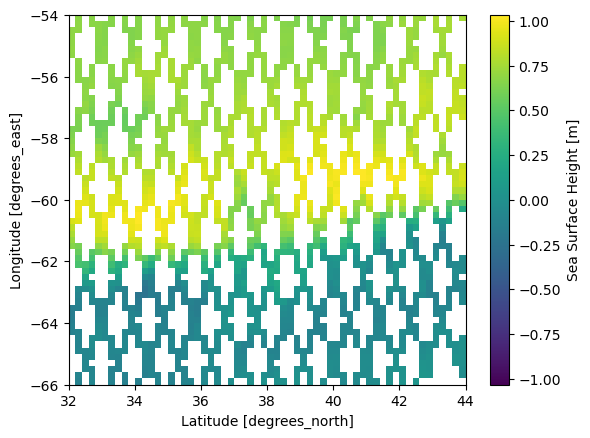

In [14]:
out.plot.pcolormesh(cmap="viridis")

### Binning - Space & Time

In [15]:
out = da_binning_2D_Time(ds.ssh, target_grid)

  0%|          | 0/7 [00:00<?, ?it/s]

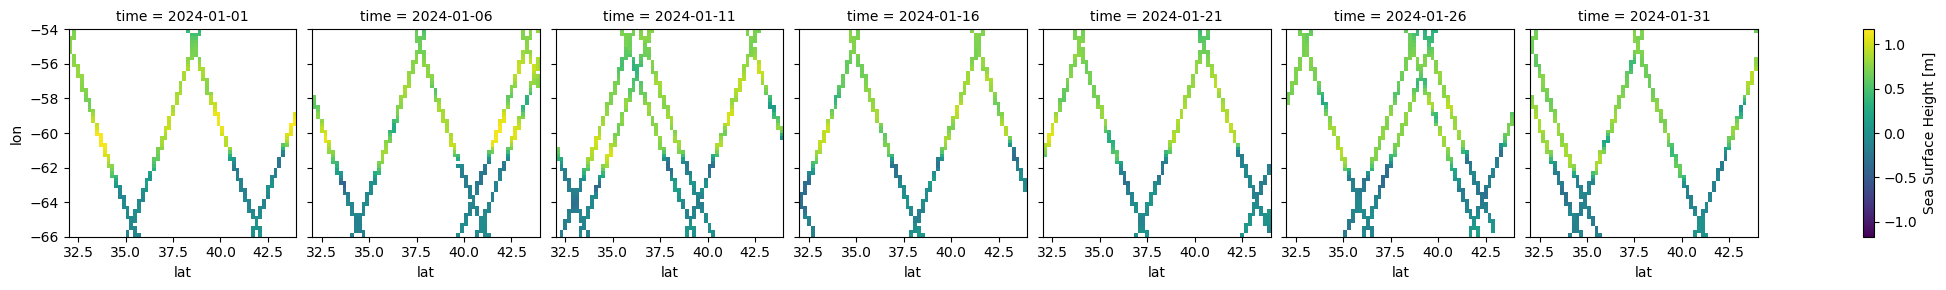

In [16]:
out.plot.pcolormesh(col="time", cmap="viridis")

### Binning - Space & Time & Variables

In [17]:
out = ds_binning_2D_Time(ds, target_grid)

  0%|          | 0/7 [00:00<?, ?it/s]

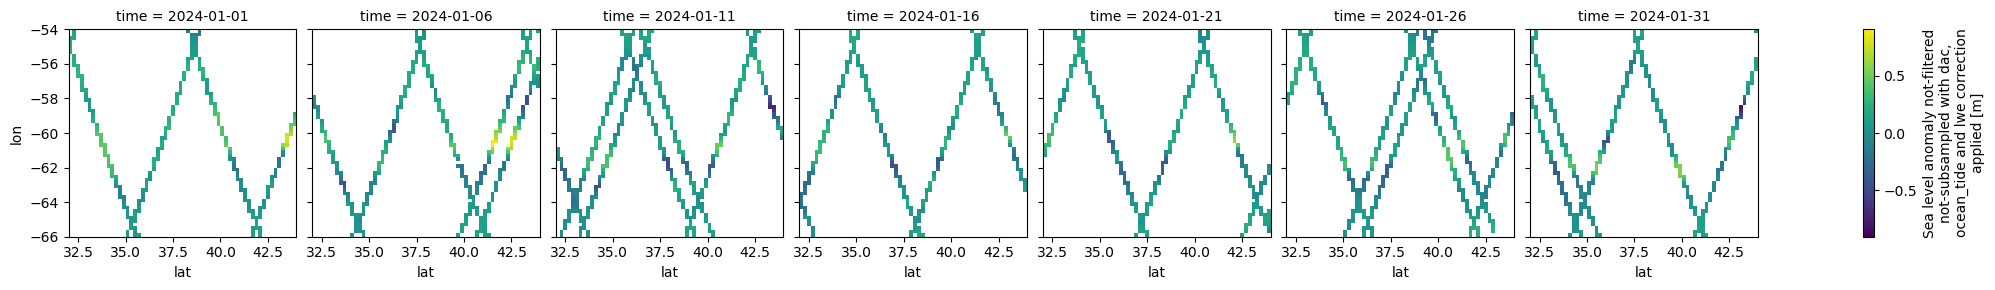

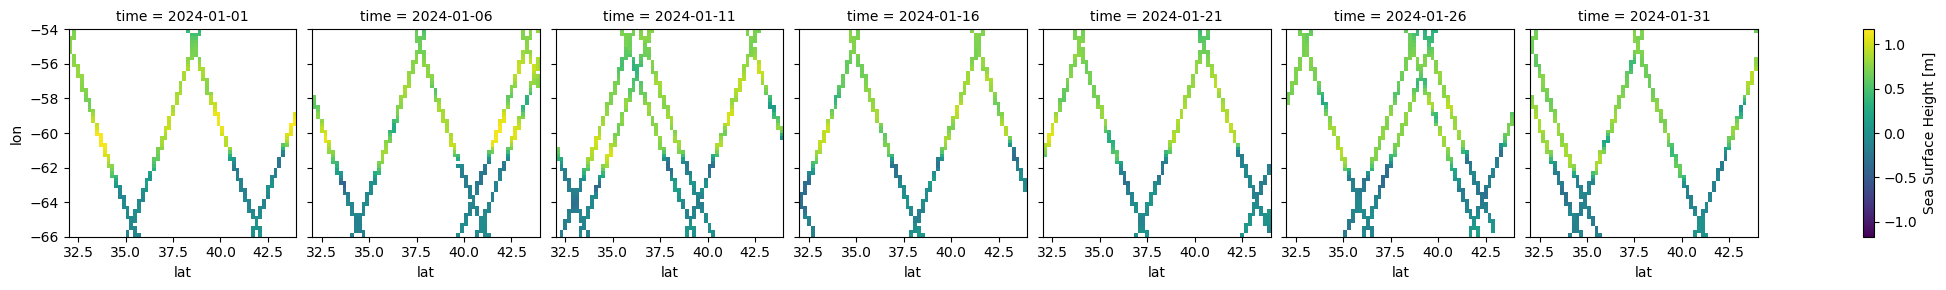

In [23]:
out.sla_unfiltered.plot.pcolormesh(col="time", cmap="viridis")
out.ssh.plot.pcolormesh(col="time", cmap="viridis")

In [18]:
# import geoviews as gv
# import geoviews.feature as gf
# import xarray as xr
# from cartopy import crs

# gv.extension('bokeh', 'matplotlib')

In [19]:
# dataset_ssh = gv.Dataset(out, ["lat", "lon", "time"], "ssh")

In [20]:
# images = dataset_ssh.to(gv.Image)

In [21]:
# images.opts(cmap="viridis", colorbar=True, width=600, height=500)